In [544]:
import torch
import pickle
import timm 
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [545]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [546]:
all_batches_data = []
all_batches_labels = []

for i in range(1, 6):
    with open(f'cifar-10-batches-py/data_batch_{i}', 'rb') as f:
        dataset_dict = pickle.load(f, encoding='bytes')
        all_batches_data.append(dataset_dict[b'data'])
        all_batches_labels.append(dataset_dict[b'labels'])

stacked_data = np.vstack(all_batches_data)
stacked_labels = np.hstack(all_batches_labels)

data = torch.tensor(stacked_data, dtype=torch.float32).view(-1, 3, 32, 32).to(device) / 255.
labels = torch.tensor(stacked_labels, dtype=torch.long).to(device)

split_idx = int(0.8 * len(data))

x_train, x_valid = data[:split_idx], data[split_idx:]
y_train, y_valid = labels[:split_idx], labels[split_idx:]

In [547]:
print(x_train.shape)
print(x_train.device)

torch.Size([40000, 3, 32, 32])
mps:0


In [548]:
class ConvNet(nn.Module):
    def __init__(self, num_channels: int, num_classes: int, filters: list[int], activation: nn.Module = nn.ReLU):
        super().__init__()
        conv_layers = [
            nn.Conv2d(num_channels, filters[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(filters[0]),
            activation()
        ]
        for i in range(len(filters)-1):
            conv_layers += [
                nn.Conv2d(filters[i], filters[i+1], kernel_size=3, stride=2, padding=1), 
                nn.BatchNorm2d(filters[i+1]),
                activation()
            ]
        
        conv_layers.append(nn.Conv2d(filters[-1], num_classes, kernel_size=3, stride=1, padding=1))
        self.conv_layers = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        h = self.conv_layers(x)
        return self.flatten(h)


In [549]:
model = ConvNet(3, 10, [64, 128, 256, 512, 1024], nn.LeakyReLU).to(device)


In [550]:
model

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affin

In [607]:
def accuracy(y_pred, y):
    return (y_pred.argmax(dim=1) == y).float().mean()

def validate_model(model, valid_loader, loss_fn):
    model.eval()
    valid_loss = []
    valid_acc = []
    with torch.no_grad():
        for batch in valid_loader:
            x, y = batch
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            valid_loss.append(loss.item())
            valid_acc.append(accuracy(y_pred, y))
    
    return sum(valid_loss) / len(valid_loss), sum(valid_acc) / len(valid_acc)

def plot_loss(all_train_loss, all_valid_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_loss, label='Training Loss')
    plt.plot(all_valid_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model: nn.Module, optim: torch.optim.Optimizer, loss_fn, train_loader, valid_loader, scheduler, epochs=10, batch_size=32, valid_every=1):
    
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        
        for batch in train_loader:
            x, y = batch
            optim.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optim.step()
            train_loss.append(loss.item())
        
        all_train_loss.append(sum(train_loss) / len(train_loss))
        scheduler.step()
        if epoch % valid_every == 0:
            valid_loss, valid_acc = validate_model(model, valid_loader, loss_fn)
            all_valid_loss.append(valid_loss)
            print(
                f"Epoch {epoch}, Train Loss: {sum(train_loss) / len(train_loss)}, "
                f"Valid Loss: {valid_loss}, "
                f"Acc: {valid_acc}"
            )
    
    plot_loss(all_train_loss, all_valid_loss)


In [600]:
from torch.utils.data import Dataset, DataLoader

class CIFARCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = CIFARCustomDataset(x_train, y_train)
valid_ds = CIFARCustomDataset(x_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

Epoch 0, Train Loss: 1.5231581486701966, Valid Loss: 1.23336019950172, Acc: 0.5675918459892273
Epoch 1, Train Loss: 1.0952899983406066, Valid Loss: 1.0871459129519356, Acc: 0.6138178706169128
Epoch 2, Train Loss: 0.8839552873373031, Valid Loss: 0.9193776482210373, Acc: 0.6823083162307739
Epoch 3, Train Loss: 0.7175399557828903, Valid Loss: 0.8598935085173232, Acc: 0.7027755379676819
Epoch 4, Train Loss: 0.5587112690329552, Valid Loss: 0.9482063294980473, Acc: 0.6814097166061401
Epoch 5, Train Loss: 0.38205424023270607, Valid Loss: 0.8314372561038873, Acc: 0.7431110143661499
Epoch 6, Train Loss: 0.2135581601768732, Valid Loss: 1.2164333525557107, Acc: 0.7079672813415527
Epoch 7, Train Loss: 0.10177411680519581, Valid Loss: 1.0171320149883294, Acc: 0.7585862874984741
Epoch 8, Train Loss: 0.04287989507000893, Valid Loss: 1.081804110457341, Acc: 0.7588858008384705
Epoch 9, Train Loss: 0.023757295804936438, Valid Loss: 1.087420758300315, Acc: 0.763079047203064


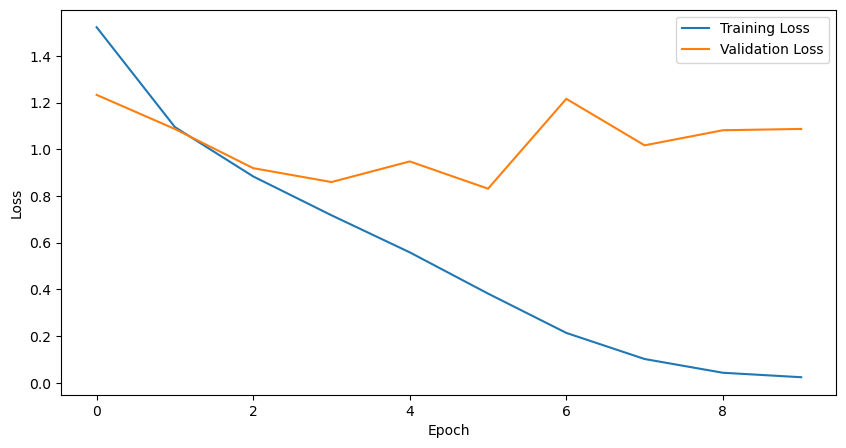

In [555]:
optim = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=10)
loss_fn = nn.CrossEntropyLoss()


train_model(model, optim, loss_fn, train_dl, valid_dl, scheduler=scheduler, epochs=10, valid_every=1)

In [601]:
class ConvBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 activation: nn.Module = nn.ReLU, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1
                 ):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding), 
            nn.BatchNorm2d(out_channels),
            activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.conv(x)

class ResBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 activation: nn.Module = nn.ReLU, 
                 kernel_size: int = 3, 
                 stride: int = 1, 
                 padding: int = 1
                 ):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, activation, kernel_size, stride, padding)

        self.idconv = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.avgpool = nn.Identity() if stride == 1 else nn.AvgPool2d(kernel_size=2, stride=stride)

        self.activation = activation()

    def forward(self, x):
        h = self.conv1(x)
        h_id = self.avgpool(self.idconv(x))
        return self.activation(h + h_id)


In [602]:
res_block = ResBlock(3, 64).to(device)
print(x_train[0].shape)
res_block(x_train[0].unsqueeze(0)).shape

for i in range(10):
    print(res_block(x_train[i].unsqueeze(0)).shape)


torch.Size([3, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])


In [603]:
class ResNet(nn.Module):
    def __init__(self,
                 num_channels: int,
                 num_classes: int,
                 filters: list[int],
                 activation: nn.Module = nn.ReLU,
                 stride: int = 2
                 ):
        super().__init__()
        res_layers = [
            ResBlock(num_channels, filters[0], activation, stride=1)
        ]
        for i in range(len(filters)-1):
            res_layers += [
                ResBlock(filters[i], filters[i+1], activation, stride=stride)
            ]
        self.res_layers = nn.Sequential(*res_layers)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(filters[-1], num_classes, bias=False),
            nn.BatchNorm1d(num_classes),
            activation()
        )

    def forward(self, x):
        for i, layer in enumerate(self.res_layers):
            x = layer(x)

        h = self.avgpool(x)
        h = self.flatten(h)
        return self.linear(h)

In [610]:
model2 = ResNet(3, 10, [32, 64, 64, 128, 256], nn.ReLU, stride=2).to(device)
model2

ResNet(
  (res_layers): Sequential(
    (0): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idconv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (avgpool): Identity()
      (activation): ReLU()
    )
    (1): ResBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNo

In [611]:
print(model.parameters())
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
print(model2.parameters())
total_params = sum(p.numel() for p in model2.parameters())
print(f"Number of parameters: {total_params}")



<generator object Module.parameters at 0x88ca2edc0>
Number of parameters: 6366730
<generator object Module.parameters at 0x88ca2edc0>
Number of parameters: 1294452


In [612]:
optim2 = torch.optim.Adam(model2.parameters(), lr=0.005, weight_decay=1e-5)
scheduler2 = torch.optim.lr_scheduler.OneCycleLR(optim2, max_lr=0.005, total_steps=10)
loss_fn = nn.CrossEntropyLoss()
train_model(model2, optim2, loss_fn, train_dl, valid_dl, scheduler=scheduler2, epochs=10, valid_every=1)

Epoch 0, Train Loss: 1.559175350856781, Valid Loss: 1.2634917474783267, Acc: 0.6050319671630859
Epoch 1, Train Loss: 1.289630014514923, Valid Loss: 1.0403183057856635, Acc: 0.6470646858215332
Epoch 2, Train Loss: 0.9706135962486268, Valid Loss: 0.8364121082682199, Acc: 0.713957667350769
Epoch 3, Train Loss: 0.7726484669446945, Valid Loss: 0.8308492492372617, Acc: 0.713957667350769
Epoch 4, Train Loss: 0.6482435059547424, Valid Loss: 0.770921632885552, Acc: 0.7414137125015259
Epoch 5, Train Loss: 0.5213794201016426, Valid Loss: 0.6677135184359627, Acc: 0.7749600410461426
Epoch 6, Train Loss: 0.3689283985495567, Valid Loss: 0.5824935553839412, Acc: 0.8121006488800049
Epoch 7, Train Loss: 0.2080702029079199, Valid Loss: 0.5457892463134881, Acc: 0.8302715420722961
Epoch 8, Train Loss: 0.10159572212845087, Valid Loss: 0.5593098759794006, Acc: 0.8370606899261475
